In [2]:
import polars as pl 
from polars import NoDataError
import numpy as np
import gff3_parser
import os 
import shutil
import yaml
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
import numpy as np
import shutil
import subprocess
from Bio import SeqIO
import re

from utils.files import multifasta_to_dict
from utils.handle_UTRs import translate_frames
from utils.process import get_specie


gff_dict = dict()
genome_dict = dict()



with open('/home/sherman/Bureau/Gits/Elongates/env.yaml', 'r') as f:
    yaml_data = yaml.safe_load(f)
    species_order = yaml_data['Species_order']['Scer']
    re_dict = yaml_data['Regex']['Scer']


for specie in species_order:

    gff_dict[specie] = pl.from_pandas(gff3_parser.parse_gff3(f"input/{specie}.gff", parse_attributes = True, verbose = False))
    genome_dict[specie] = multifasta_to_dict(f"input/{specie}.fna", genome = True)


cov = 0.5
coeff = 2
seuil = 4

current_path = f"/home/sherman/Bureau/Gits/Elongates/work/{cov}"
elongates = pl.read_csv(f"output/{cov}/{cov}_elongates.csv", infer_schema_length =100000)


def custom_target_elongate(cluster, scer_length, seq_id, specie, elongate_length, side, genome_dict, gff_dict, coeff = 1): 


    coordinates = list()
    result_dict = dict()

    if side != "Nter" and side != "Cter":

        raise ValueError("Side must be either Nter or Cter")
    
    gff = gff_dict[specie].filter(

        (pl.col("Type") == "CDS") & ((pl.col("Name") == seq_id) | (pl.col("Parent") == seq_id))

    )[["Start","End","Strand","Seqid"]] # Keep only necessary columns
    
    # Store datas necessary to compute the elongate sequence

    strand = gff[0]["Strand"].to_list()[0] # + or -
    strand_id = gff[0]["Seqid"].to_list()[0] # chromosome or scaffold id

    for row in gff.iter_rows(named=True): # Named = True to iter with column names

        coordinates.append(sorted((int(row['Start'])-1, int(row['End'])-1))) # -1 for python indexing
        
    coordinates = sorted(coordinates, key=lambda x: x[0]) # Sort coordinates by start position


    custom_elongate_length = int(np.ceil((scer_length - elongate_length) * 3 * coeff)) # Get the length of the elongate sequence in nucleotides

    if strand == "+":

        if side == "Nter":

            start_5 = coordinates[0][0]-custom_elongate_length if coordinates[0][0]-custom_elongate_length >= 0 else 0 # Get the start position of the 5' UTR
            
            elongate = genome_dict[specie][strand_id]["seq"][

                start_5:coordinates[0][0]

            ] 

        elif side == "Cter": # Useless check but it's for the sake of clarity
        
            end_3 = coordinates[-1][1]+1+custom_elongate_length if coordinates[-1][1]+1+custom_elongate_length <= genome_dict[specie][strand_id]["len"] else genome_dict[specie][strand_id]["len"] # Get the end position of the 3' UTR
            # +1 for -1,1 because GFF points to the last nucleotide of the stop codon

            elongate = genome_dict[specie][strand_id]["seq"][
                coordinates[-1][1]+1:end_3
                ] # Get the 3' sequence

    
    # Reverse complement if the strand is negative, don't forget to reverse the coordinates
    if strand == "-":

        if side == "Nter":

            end_5 = coordinates[-1][1]+1+custom_elongate_length if coordinates[-1][1]+1+custom_elongate_length <= genome_dict[specie][strand_id]["len"] else genome_dict[specie][strand_id]["len"] # Get the start position of the 5' UTR

            elongate = genome_dict[specie][strand_id]["seq"][
                coordinates[-1][1]+1:end_5
            ].reverse_complement() # Get the 5' sequence
        

        if side == "Cter":
        
            start_3 = coordinates[0][0]-custom_elongate_length if coordinates[0][0]-custom_elongate_length >= 0 else 0 # Get the end position of the 3' UTR

            elongate = genome_dict[specie][strand_id]["seq"][
                start_3:coordinates[0][0]
            ].reverse_complement() # Get the 3' sequence


    result_dict["nuc"] = SeqRecord(seq = Seq(elongate), id = f"{seq_id}", description = "") 

    # def translate_frames(dna_sequence, specie, seq_id, length, utr, cluster)

    result_dict["prot"] = translate_frames(dna_sequence = elongate, specie = specie, seq_id = seq_id, length = custom_elongate_length, utr = side, cluster = cluster)

    return result_dict
    
    
def custom_scer_elongates(scer_id : str, specie : str, scer_length : int, scer_elongate : str or Seq, infos_dict, cluster, gff_dict, genome_dict, side):

    coordinates = list()
    result_dict = dict()


    ########
    # Get infos from gff file 
    ########

    if side != "Nter" and side != "Cter":

        raise ValueError("Side must be either Nter or Cter")
    
    gff = gff_dict[specie].filter(

        (pl.col("Type") == "CDS") & ((pl.col("Name") == scer_id) | (pl.col("Parent") == scer_id))

    )[["Start","End","Strand","Seqid"]] # Keep only necessary columns
    
    # Store datas necessary to compute the elongate sequence

    strand = gff[0]["Strand"].to_list()[0] # + or -
    strand_id = gff[0]["Seqid"].to_list()[0] # chromosome or scaffold id

    for row in gff.iter_rows(named=True): 

        coordinates.append(sorted((int(row['Start'])-1, int(row['End'])-1))) # -1 for python indexing
        
    coordinates = sorted(coordinates, key=lambda x: x[0]) # Sort coordinates by start position

    ########
    # Check that input data are correct
    ########

    scer_elongate = scer_elongate.replace("-","")

    if len(scer_elongate) != scer_length:

        print(f"Seq id : {scer_id}")
        print(f"Cluster : {cluster}")
        raise ValueError("Mismatch between theorical and real length of the Scer peptidic elongate")

    for subject_id, subject_length in infos_dict.items():

        result_dict[subject_id] = dict()
        custom_length = (scer_length-subject_length)*3

        if strand == "+":

            if side == "Nter":
                
               nuc_elongate = genome_dict[specie][strand_id]["seq"][

                    coordinates[0][0]:coordinates[0][0] + custom_length # Get the 5' sequence

                ] 

            elif side == "Cter": # Useless check but it's for the sake of clarity
            

                nuc_elongate = genome_dict[specie][strand_id]["seq"][
                    
                    coordinates[-1][1]-(custom_length):coordinates[-1][1]] # Get the 3' sequence

    
        # Reverse complement if the strand is negative, don't forget to reverse the coordinates
        if strand == "-":

            if side == "Nter":


                nuc_elongate = genome_dict[specie][strand_id]["seq"][
                    coordinates[-1][1]-(custom_length):coordinates[-1][1]
                ].reverse_complement() # Get the 5' sequence
            

            elif side == "Cter":
            
                nuc_elongate = genome_dict[specie][strand_id]["seq"][
                    coordinates[0][0]:coordinates[0][0] + (custom_length)
                ].reverse_complement() # Get the 3' sequence



        result_dict[subject_id]["nuc"] = SeqRecord( seq = Seq(nuc_elongate), id = f"{scer_id}", description = "")
        result_dict[subject_id]["prot"] = SeqRecord( seq = Seq(scer_elongate[:int(custom_length/3)]), id = f"{scer_id}", description = "")
    
    return result_dict


def parse_prot_id(row : tuple) -> tuple:


    prot_subject_pattern = r'(.*?)-(cluster_n\d+)-(.*)-(f\d+)-(\d+)'

    query_id = row[0]
    subject_id = row[1]
    identity = row[2]
    align_lenght = row[3]
    mismatches = row[4]
    gap_opens = row[5]
    qstart = row[6]
    qend = row[7]
    sstart = row[8]
    send = row[9]
    evalue = row[10]
    bitscore = row[11]
    condition = row[12]
    side = row[13]

    match = re.search(prot_subject_pattern, subject_id)


    if match:

        subject_id = match.group(1)
        cluster = match.group(2)
        relative_frame = match.group(4)


    q_specie = get_specie(re_dict, query_id)
    s_specie = get_specie(re_dict, subject_id)

    return (query_id, subject_id, identity, align_lenght, mismatches, gap_opens, qstart, qend, sstart, send, evalue, bitscore, condition, side, relative_frame, q_specie, s_specie)


def parse_nuc_id(row : tuple) -> tuple:


    query_id = row[0]
    subject_id = row[1]
    identity = row[2]
    align_lenght = row[3]
    mismatches = row[4]
    gap_opens = row[5]
    qstart = row[6]
    qend = row[7]
    sstart = row[8]
    send = row[9]
    evalue = row[10]
    bitscore = row[11]
    condition = row[12]
    side = row[13]

    q_specie = get_specie(re_dict, query_id)
    s_specie = get_specie(re_dict, subject_id)

    return (query_id, subject_id, identity, align_lenght, mismatches, gap_opens, qstart, qend, sstart, send, evalue, bitscore, condition, side, "NA", q_specie, s_specie)


Nter_scer_conditions = ((pl.col("species") == "Scer_NCBI") & (abs(pl.col("max_Nter") - pl.col("Nter_nb_aa")) < seuil) & (pl.col("max_Nter") >= 10))
Cter_scer_conditions = ((pl.col("species") == "Scer_NCBI") & (abs(pl.col("max_Cter") - pl.col("Cter_nb_aa")) < seuil) & (pl.col("max_Cter") >= 10))
test = elongates.filter(Nter_scer_conditions | Cter_scer_conditions)["cluster_name"].unique().to_list()

nter_clusters = []
cter_clusters = []
i = 0

for cluster,sequences in elongates.filter(pl.col("cluster_name").is_in(test)).groupby("cluster_name"):

    species = sequences["species"].to_list()

    if len(species) < 3:
            
        continue


    species_ordered = [ s for s in species_order if s in species]
    
    if species_ordered[-1] != "Scer_NCBI" and species.count(species_ordered[-1]) > 1:
            
        continue

    if sequences.filter(pl.col("species") == species_ordered[-1])["Nter_nb_aa"].to_list()[0] < seuil and sequences["max_Nter"].max() >= 10:
    
        nter_clusters.append(cluster)

    if sequences.filter(pl.col("species") == species_ordered[-1])["Cter_nb_aa"].to_list()[0] < seuil and sequences["max_Cter"].max() >= 10:
    
        cter_clusters.append(cluster)



full_filtered_Nter = elongates.filter(pl.col("cluster_name").is_in(nter_clusters))
full_filtered_Cter = elongates.filter(pl.col("cluster_name").is_in(cter_clusters))

dataframes = {
        "Nter": full_filtered_Nter,
        "Cter": full_filtered_Cter,
    }

current_path = f"/home/sherman/Bureau/Gits/Elongates/work/{cov}"

if os.path.exists(f"{current_path}/local_align_files"):

    shutil.rmtree(f"{current_path}/local_align_files")

os.mkdir(f"{current_path}/local_align_files")

for side in ["Nter", "Cter"]:

    df = dataframes[side]

    os.mkdir(f"{current_path}/local_align_files/{side}")

    for cluster, sequences in df.groupby("cluster_name"):

        scer_length = sequences.filter(pl.col("species") == "Scer_NCBI")[f"{side}_nb_aa"].max() # Maybe several Scer sequences in the cluster, we take the longest elongate
        
        if scer_length < 10:
            continue

        scer_id = sequences.filter((pl.col("species") == "Scer_NCBI") & (pl.col(f"{side}_nb_aa") == scer_length))["seq_id"].to_list()[0]
        os.mkdir(f"{current_path}/local_align_files/{side}/{cluster}")
    
        infos_for_scer_sequences = dict()
        for sequence in sequences.iter_rows(named = True): 

            if scer_length - sequence[f"{side}_nb_aa"] >= 10:


                os.mkdir(f"{current_path}/local_align_files/{side}/{cluster}/{sequence['seq_id']}")
                os.mkdir(f"{current_path}/local_align_files/{side}/{cluster}/{sequence['seq_id']}/nucleotide")
                os.mkdir(f"{current_path}/local_align_files/{side}/{cluster}/{sequence['seq_id']}/protein")


                dict_ = custom_target_elongate(cluster, scer_length, sequence["seq_id"], sequence["species"], sequence[f"{side}_nb_aa"], side, genome_dict, gff_dict, coeff = coeff)

            
                
                SeqIO.write(dict_["nuc"], f"{current_path}/local_align_files/{side}/{cluster}/{sequence['seq_id']}/nucleotide/{sequence['seq_id']}.fna", "fasta")
                
                SeqIO.write([ seq for seq in dict_["prot"].values()], f"{current_path}/local_align_files/{side}/{cluster}/{sequence['seq_id']}/protein/{sequence['seq_id']}.faa", "fasta")
                
                infos_for_scer_sequences[sequence["seq_id"]] = sequence[f"{side}_nb_aa"] 
                
        
        scer_cds = sequences.filter(pl.col("seq_id") == scer_id)
        
        scer_elongates = custom_scer_elongates(scer_id = scer_id, specie = "Scer_NCBI", scer_length = scer_length, 
                                                    scer_elongate = scer_cds[f"{side}_elongate"].to_list()[0], infos_dict = infos_for_scer_sequences, 
                                                    cluster = cluster, gff_dict = gff_dict, genome_dict = genome_dict, side = side)


        for subject_sequence in scer_elongates.keys():

            SeqIO.write(scer_elongates[subject_sequence]["nuc"], f"{current_path}/local_align_files/{side}/{cluster}/{subject_sequence}/nucleotide/{scer_id}_custom.fna", "fasta")
            SeqIO.write(scer_elongates[subject_sequence]["prot"], f"{current_path}/local_align_files/{side}/{cluster}/{subject_sequence}/protein/{scer_id}_custom.faa", "fasta")


if os.path.exists(f"{current_path}/local_align_files"):

    shutil.rmtree(f"{current_path}/local_align_files")

os.mkdir(f"{current_path}/local_align_files")

for side in ["Nter", "Cter"]:

    df = dataframes[side]

    os.mkdir(f"{current_path}/local_align_files/{side}")

    for cluster, sequences in df.groupby("cluster_name"):

        scer_length = sequences.filter(pl.col("species") == "Scer_NCBI")[f"{side}_nb_aa"].max() # Maybe several Scer sequences in the cluster, we take the longest elongate
        
        if scer_length < 10:
            continue

        scer_id = sequences.filter((pl.col("species") == "Scer_NCBI") & (pl.col(f"{side}_nb_aa") == scer_length))["seq_id"].to_list()[0]
        os.mkdir(f"{current_path}/local_align_files/{side}/{cluster}")
    
        infos_for_scer_sequences = dict()
        for sequence in sequences.iter_rows(named = True): 

            if scer_length - sequence[f"{side}_nb_aa"] >= 10:


                os.mkdir(f"{current_path}/local_align_files/{side}/{cluster}/{sequence['seq_id']}")
                os.mkdir(f"{current_path}/local_align_files/{side}/{cluster}/{sequence['seq_id']}/nucleotide")
                os.mkdir(f"{current_path}/local_align_files/{side}/{cluster}/{sequence['seq_id']}/protein")


                dict_ = custom_target_elongate(cluster, scer_length, sequence["seq_id"], sequence["species"], sequence[f"{side}_nb_aa"], side, genome_dict, gff_dict)

            
                
                SeqIO.write(dict_["nuc"], f"{current_path}/local_align_files/{side}/{cluster}/{sequence['seq_id']}/nucleotide/{sequence['seq_id']}.fna", "fasta")
                
                SeqIO.write([ seq for seq in dict_["prot"].values()], f"{current_path}/local_align_files/{side}/{cluster}/{sequence['seq_id']}/protein/{sequence['seq_id']}.faa", "fasta")
                
                infos_for_scer_sequences[sequence["seq_id"]] = sequence[f"{side}_nb_aa"] 
                
        
        scer_cds = sequences.filter(pl.col("seq_id") == scer_id)
        
        scer_elongates = custom_scer_elongates(scer_id = scer_id, specie = "Scer_NCBI", scer_length = scer_length, 
                                                    scer_elongate = scer_cds[f"{side}_elongate"].to_list()[0], infos_dict = infos_for_scer_sequences, 
                                                    cluster = cluster, gff_dict = gff_dict, genome_dict = genome_dict, side = side)


        for subject_sequence in scer_elongates.keys():

            SeqIO.write(scer_elongates[subject_sequence]["nuc"], f"{current_path}/local_align_files/{side}/{cluster}/{subject_sequence}/nucleotide/{scer_id}_custom.fna", "fasta")
            SeqIO.write(scer_elongates[subject_sequence]["prot"], f"{current_path}/local_align_files/{side}/{cluster}/{subject_sequence}/protein/{scer_id}_custom.faa", "fasta")


# Fields: query id, subject id, % identity, alignment length, mismatches, gap opens, q. start, q. end, s. start, s. end, evalue, bit score
dtypes = [pl.Utf8, pl.Utf8, pl.Float64, pl.Int64, pl.Int64, pl.Int64, pl.Int64, pl.Int64, pl.Int64, pl.Int64, pl.Float64, pl.Float64]
dfs = list()
trunc_files = open(f"output/{cov}/trunc_files.txt", "a")
current_path = f"/home/sherman/Bureau/Gits/Elongates/work/{cov}/local_align_files"

for side in os.listdir(current_path):

    for cluster in os.listdir(f"{current_path}/{side}"):

        for subject_seq in os.listdir(f"{current_path}/{side}/{cluster}"):

            for condition in ["nucleotide","protein"]:

                root = f"{current_path}/{side}/{cluster}/{subject_seq}/{condition}/"
                output_csv = os.path.join(root,"temp.tsv")      

                if os.path.exists(output_csv):
                    os.remove(output_csv)

                to_align = os.listdir(f"{current_path}/{side}/{cluster}/{subject_seq}/{condition}")

                query_index = next((i for i, item in enumerate(to_align) if "custom" in item))
                subject_index = not query_index # List length 2 in every scenario

                query = os.path.join(root, to_align[query_index])
                subject = os.path.join(root, to_align[subject_index])      
                
                if condition == "nucleotide":
                    command = f"lalign36 -3 -E 1000 -m 8 {query} {subject} > {output_csv}"
                elif condition == "protein":
                    command = f"lalign36 -p -3 -E 1000 -m 8 {query} {subject} > {output_csv}"
                
                subprocess.run(command, shell=True)
                try:
                    df = pl.read_csv(output_csv, separator="\t", has_header=False, dtypes = dtypes)
                except:
                    trunc_files.write(f"{query}\n{subject_index}\n----------------\n")
                    NoDataError()

                if condition == "nucleotide":
                    df = df.sort("column_11", descending = False).head(1).with_columns(
                        column_13 = pl.lit(condition),
                        column_14 = pl.lit(side))

                if condition == "protein":
                    tmp_ = []
                    for frame, align_res in df.groupby("column_2"):
                        tmp_.append(align_res.sort("column_11", descending = False).head(1).with_columns(
                            column_13 = pl.lit(condition),
                            column_14 = pl.lit(side)))
                    df = pl.concat(tmp_)

                dfs.append(df)
                os.remove(output_csv)
                            
df = pl.concat(dfs)
trunc_files.close()

df = pl.concat(dfs)
df = df.with_columns(
    
    pl.lit("NA").alias('column_15'),
    pl.lit("NA").alias('column_16'),
    pl.lit("NA").alias('column_17')
)

prot = df.filter(pl.col("column_13") == "protein").apply(parse_prot_id)
nuc = df.filter(pl.col("column_13") == "nucleotide").apply(parse_nuc_id)


df = pl.concat([prot, nuc]).rename({
    "column_0": "query_id",
    "column_1": "subject_id",
    "column_2": "identity",
    "column_3": "align_lenght",
    "column_4": "mismatches",
    "column_5": "gap_opens",
    "column_6": "qstart",
    "column_7": "qend",
    "column_8": "sstart",
    "column_9": "send",
    "column_10": "evalue",
    "column_11": "bitscore",
    "column_12": "condition",
    "column_13": "side",
    "column_14": "relative_frame",
    "column_15": "q_specie",
    "column_16": "s_specie"
}).sort("query_id","subject_id")



In [21]:
df.filter(pl.col("query_id") == "rna-NM_001181048.1")

query_id,subject_id,identity,align_lenght,mismatches,gap_opens,qstart,qend,sstart,send,evalue,bitscore,condition,side,relative_frame,q_specie,s_specie
str,str,f64,i64,i64,i64,i64,i64,i64,i64,f64,f64,str,str,str,str,str
"""rna-NM_0011810…","""Sarb_07G00730.…",97.73,44,1,0,2,45,2,45,3.5000e-27,100.5,"""protein""","""Nter""","""f0""","""Scer_NCBI""","""Sarb"""
"""rna-NM_0011810…","""Sarb_07G00730.…",21.05,38,30,0,2,39,2,39,0.051,16.8,"""protein""","""Nter""","""f1""","""Scer_NCBI""","""Sarb"""
"""rna-NM_0011810…","""Sarb_07G00730.…",22.22,36,28,0,4,39,4,39,0.17,15.1,"""protein""","""Nter""","""f2""","""Scer_NCBI""","""Sarb"""
"""rna-NM_0011810…","""Sarb_07G00730.…",86.79,53,7,0,83,135,1,53,2.7000e-11,49.2,"""nucleotide""","""Nter""","""NA""","""Scer_NCBI""","""Sarb"""
"""rna-NM_0011810…","""rna-XM_0339103…",21.88,32,25,0,11,42,11,42,0.15,15.3,"""protein""","""Nter""","""f1""","""Scer_NCBI""","""Spar_NCBI"""
"""rna-NM_0011810…","""rna-XM_0339103…",33.33,9,6,0,6,14,6,14,1.7,11.2,"""protein""","""Nter""","""f2""","""Scer_NCBI""","""Spar_NCBI"""
"""rna-NM_0011810…","""rna-XM_0339103…",100.0,44,0,0,2,45,2,45,7.8000e-33,119.2,"""protein""","""Nter""","""f0""","""Scer_NCBI""","""Spar_NCBI"""
"""rna-NM_0011810…","""rna-XM_0339103…",92.45,53,4,0,83,135,1,53,1.2000e-12,53.8,"""nucleotide""","""Nter""","""NA""","""Scer_NCBI""","""Spar_NCBI"""


In [3]:
nter = df.filter(pl.col("side") == "Nter").sort("query_id","subject_id")
cter = df.filter(pl.col("side") == "Cter").sort("query_id","subject_id")

# test = nter.join(elongates, left_on = "query_id", right_on = "seq_id", how = "inner").sort("query_id","subject_id")


#####

# CTER

#####

# Filtering for protein conditions only
protein_df = cter.filter(cter['condition'] == "protein")

# Sorting by query_id and evalue
sorted_df = protein_df.sort(['query_id', 'evalue'])

# Getting the row with the minimum evalue for each query
best_protein_df = sorted_df.groupby('query_id','subject_id').agg(pl.col('evalue').first().alias('evalue'),
                                                   
                                                   pl.col('s_specie').first().alias('s_specie'),
                                                   pl.col('condition').first().alias('condition'),
                                                   pl.col("q_specie").first().alias("q_specie"),
                                                    pl.col("side").first().alias("side")
                                                  
                                                   )

nuc_df = cter.filter(cter['condition'] == "nucleotide").select("query_id","subject_id","evalue","s_specie","condition","q_specie","side")

cter = pl.concat([best_protein_df,nuc_df])


#####

# NTER 

#####


# Filtering for protein conditions only
protein_df = nter.filter(nter['condition'] == "protein")

# Sorting by query_id and evalue
sorted_df = protein_df.sort(['query_id', 'evalue'])

# Getting the row with the minimum evalue for each query
best_protein_df = sorted_df.groupby('query_id','subject_id').agg(pl.col('evalue').first().alias('evalue'),
                                                   
                                                   pl.col('s_specie').first().alias('s_specie'),
                                                   pl.col('condition').first().alias('condition'),
                                                   pl.col("q_specie").first().alias("q_specie"),
                                                    pl.col("side").first().alias("side")
                                                  
                                                   )

nuc_df = nter.filter(nter['condition'] == "nucleotide").select("query_id","subject_id","evalue","s_specie","condition","q_specie","side")

nter = pl.concat([best_protein_df,nuc_df])


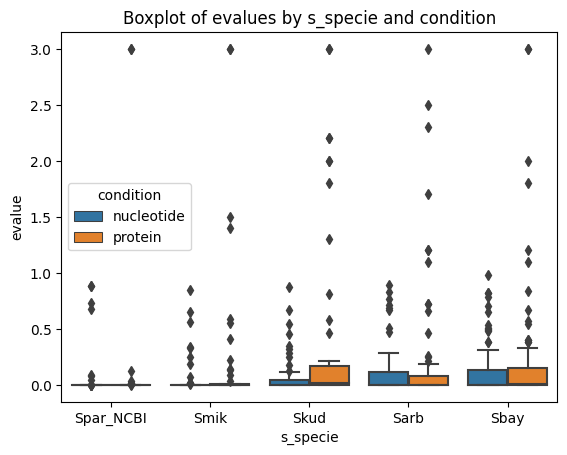

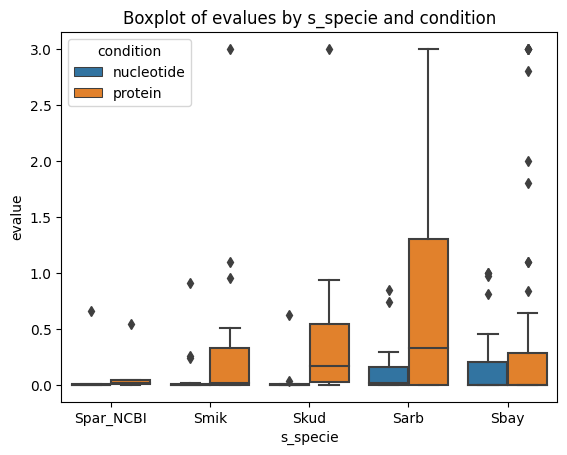

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 

CSTE = 1e-100

# Plot for Nter
data = nter.filter(pl.col("s_specie") != "Scer_NCBI").to_pandas()

yrange = (0, 80)
plt.figure()

sns.boxplot( x=data["s_specie"], y= data["evalue"], hue=data["condition"], order = ["Spar_NCBI","Smik","Skud","Sarb","Sbay"], hue_order = ["nucleotide","protein"])
  # log scale for better visibility of evalues
plt.title("Boxplot of evalues by s_specie and condition")
plt.show()


# Plot for Cter
data = cter.filter(pl.col("s_specie") != "Scer_NCBI").to_pandas()

yrange = (0, 80)
plt.figure()

sns.boxplot( x=data["s_specie"], y= data["evalue"], hue=data["condition"], order = ["Spar_NCBI","Smik","Skud","Sarb","Sbay"], hue_order = ["nucleotide","protein"])

plt.title("Boxplot of evalues by s_specie and condition")
plt.show()

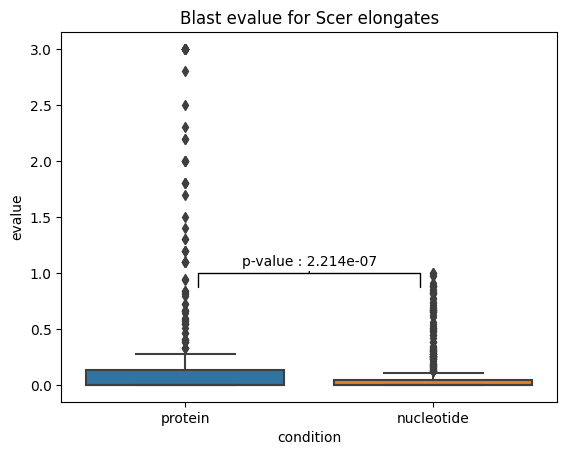

In [5]:
full_pdf = pl.concat((nter,cter)).select("evalue","condition").to_pandas()
from scipy.stats import ttest_ind



plt.figure()

sns.boxplot(data = full_pdf, x = "condition", y = "evalue")
plt.title("Blast evalue for Scer elongates")

groupA = full_pdf[full_pdf['condition'] == 'protein']['evalue']
groupB = full_pdf[full_pdf['condition'] == 'nucleotide']['evalue']
t_stat, p_value = ttest_ind(groupA, groupB)

# Annotate the p-value with significance level
plt.annotate(f'p-value : {np.around(p_value,10)}', xy=(0.5, 1), xytext=(0.5, 1.1), ha='center', va='center', arrowprops=dict(facecolor='black', arrowstyle='-[, widthB=8, lengthB=1', lw=1))


plt.show()

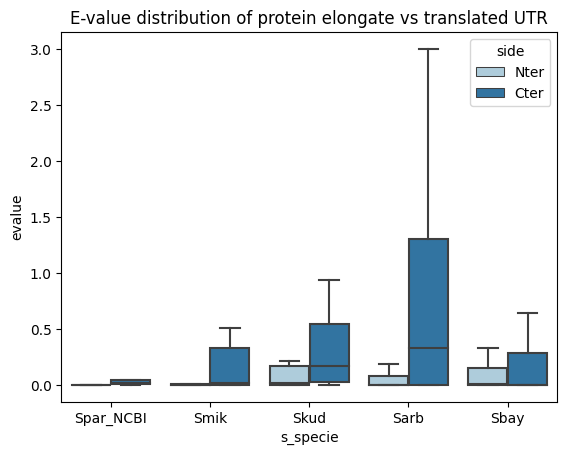

In [10]:
data = pl.concat((nter,cter)).filter(pl.col("condition") == "protein").select("evalue","s_specie","side").to_pandas()

plt.figure()

plt.title("E-value distribution of protein elongate vs translated UTR")
plt.xlabel("E-value")
plt.ylabel("Frequency")
sns.boxplot(data = data, x = "s_specie", y = "evalue",  order = ["Spar_NCBI","Smik","Skud","Sarb","Sbay"], hue = "side", palette = "Paired", showfliers = False)
plt.show()

In [15]:
nter_elong = nter.join(elongates, left_on = "query_id", right_on = "seq_id", how = "inner").sort("query_id","subject_id")
cter_elong = cter.join(elongates, left_on = "query_id", right_on = "seq_id", how = "inner").sort("query_id","subject_id")

nter_elong.columns



['query_id',
 'subject_id',
 'evalue',
 's_specie',
 'condition',
 'q_specie',
 'side',
 'cluster_size',
 'cluster_name',
 'species',
 'sequence',
 'sequence_length',
 'Nter_dashes',
 'Cter_dashes',
 'max_Nter',
 'max_Cter',
 'Nter_elongate',
 'Nter_gaps',
 'Nter_gap_openings',
 'Nter_nb_aa',
 'Nter_elongate_length',
 'Cter_elongate',
 'Cter_gaps',
 'Cter_gap_openings',
 'Cter_nb_aa',
 'Cter_elongate_length',
 'Nter_ratio',
 'Cter_ratio',
 'is_max_Nter',
 'is_max_Cter',
 'is_min_Nter',
 'is_min_Cter',
 'Meth_after_Nter',
 'Nter_event_ID',
 'Cter_event_ID',
 'Nter_events',
 'Cter_events',
 'unique_species']

/home/sherman/.local/lib/python3.10/site-packages/polars/series/series.py:1148: RuntimeWarning: divide by zero encountered in log10
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))


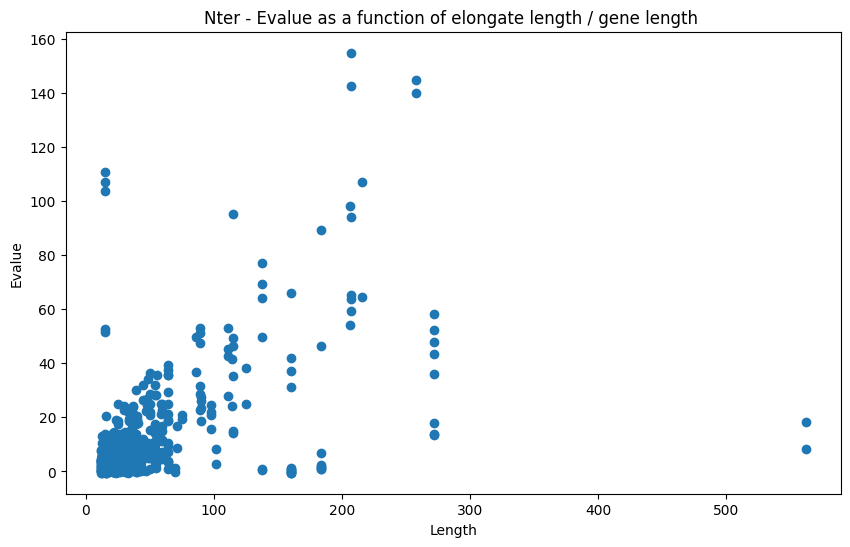

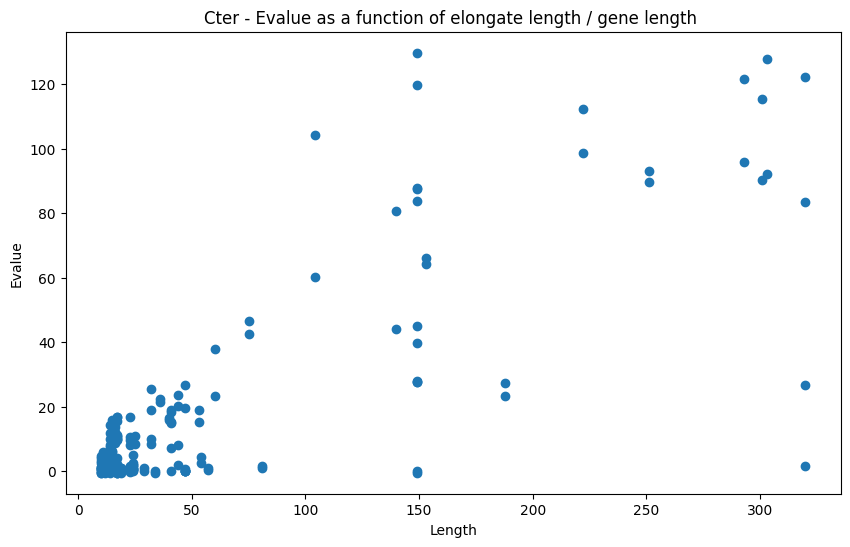

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(nter_elong['Nter_nb_aa'], -np.log10(nter_elong['evalue']) + CSTE)
plt.xlabel('Length')
plt.ylabel('Evalue')
plt.title('Nter - Evalue as a function of elongate length / gene length ')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(cter_elong['Cter_nb_aa'], -np.log10(cter_elong['evalue']) + CSTE)
plt.xlabel('Length')
plt.ylabel('Evalue')
plt.title('Cter - Evalue as a function of elongate length / gene length ')
plt.show()

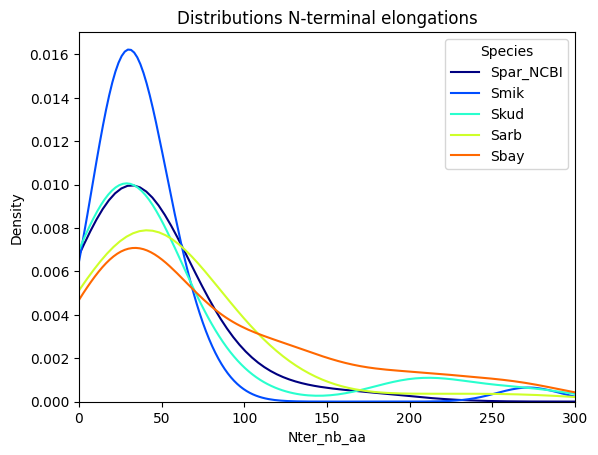

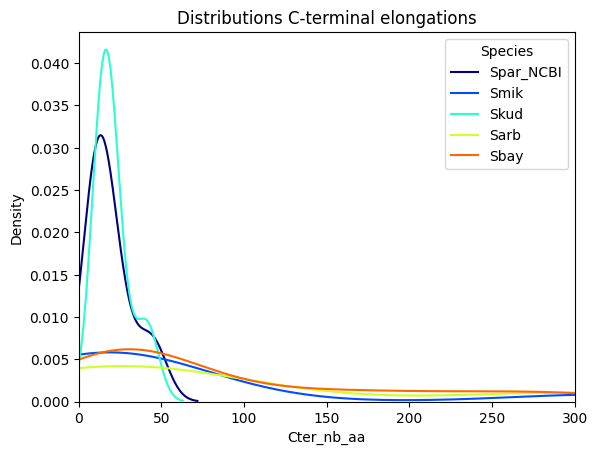

In [109]:
cmap = plt.get_cmap('jet', len(species_order))  
colors = [cmap(i) for i in range(cmap.N)]
color_map = dict(zip(["Spar_NCBI","Smik", "Skud","Sarb","Sbay"], colors))

data = nter_elong.filter(pl.col("evalue") < 1e-3).to_pandas()


x_range = (0, 300)  # Set your desired x-axis range

# Generate KDE plot for each species
for species in ["Spar_NCBI","Smik", "Skud","Sarb","Sbay"]:
    species_data = data[data["s_specie"] == species]
    sns.kdeplot(x=species_data['Nter_nb_aa'], label=species, color=color_map[species])

# Set the range of x-axis
plt.xlim(x_range)
plt.title('Distributions N-terminal elongations')
plt.ylabel('Density')
plt.legend(title='Species')
plt.show()

data = cter_elong.filter(pl.col("evalue") < 1e-3).to_pandas()
x_range = (0, 300)  # Set your desired x-axis range

# Generate KDE plot for each species
for species in ["Spar_NCBI","Smik", "Skud","Sarb","Sbay"]:
    species_data = data[data["s_specie"] == species]
    sns.kdeplot(x=species_data['Cter_nb_aa'], label=species, color=color_map[species])

# Set the range of x-axis
plt.xlim(x_range)
plt.title('Distributions C-terminal elongations')
plt.ylabel('Density')
plt.legend(title='Species')
plt.show()


In [93]:
data

,query_id,subject_id,evalue,s_specie,condition,q_specie,side,cluster_size,cluster_name,species,...,is_max_Nter,is_max_Cter,is_min_Nter,is_min_Cter,Meth_after_Nter,Nter_event_ID,Cter_event_ID,Nter_events,Cter_events,unique_species
0,rna-NM_001178148.1,Sarb_01G00560.1,0.000000e+00,Sarb,protein,Scer_NCBI,Nter,3,cluster_n4514,Scer_NCBI,...,1,1,0,1,1,2,0,2,0,3
1,rna-NM_001178148.1,Sarb_01G00560.1,0.000000e+00,Sarb,nucleotide,Scer_NCBI,Nter,3,cluster_n4514,Scer_NCBI,...,1,1,0,1,1,2,0,2,0,3
2,rna-NM_001178148.1,rna-XM_033908579.1,3.100000e-21,Spar_NCBI,protein,Scer_NCBI,Nter,3,cluster_n4514,Scer_NCBI,...,1,1,0,1,1,2,0,2,0,3
3,rna-NM_001178148.1,rna-XM_033908579.1,7.600000e-09,Spar_NCBI,nucleotide,Scer_NCBI,Nter,3,cluster_n4514,Scer_NCBI,...,1,1,0,1,1,2,0,2,0,3
4,rna-NM_001178201.2,Sarb_01G00040.1,2.200000e+00,Sarb,protein,Scer_NCBI,Nter,6,cluster_n4938,Scer_NCBI,...,1,1,0,1,1,1,0,1,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,rna-NM_001184633.1,rna-NM_001184623.1,1.200000e-12,Scer_NCBI,nucleotide,Scer_NCBI,Nter,3,cluster_n4245,Scer_NCBI,...,1,1,0,0,1,1,1,1,1,1
612,rna-NM_001184633.1,rna-NM_001267862.1,2.900000e-04,Scer_NCBI,protein,Scer_NCBI,Nter,3,cluster_n4245,Scer_NCBI,...,1,1,0,0,1,1,1,1,1,1
613,rna-NM_001184633.1,rna-NM_001267862.1,1.000000e-11,Scer_NCBI,nucleotide,Scer_NCBI,Nter,3,cluster_n4245,Scer_NCBI,...,1,1,0,0,1,1,1,1,1,1
614,rna-NM_001184647.4,Sbay_7.233,7.800000e-03,Sbay,protein,Scer_NCBI,Nter,6,cluster_n7084,Scer_NCBI,...,1,0,0,1,0,1,0,1,0,6
